In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '..')

import numpy as np
from io import StringIO
import pandas as pd

from battleship.agents import RandomCaptain, MAPCaptain, ProbabilisticCaptain, CodeSpotterModel
from battleship.board import Board
from battleship.game import BattleshipGame
from battleship.agents import CacheMode

In [3]:
stage_df = pd.read_csv("/home/ubuntu/repo_battleship/temp/gold_annotations_partial.csv")
round_df = pd.read_csv("/home/ubuntu/repo_battleship/battleship/experiments/collaborative/battleship-final-data/round.csv")
goldAnnotations=["answer", "ambiguous", "contextual", "unanswerable"]

board_ids = round_df[["id", "board_id"]]

filtered_stage_df = stage_df[
    [
        "roundID",
        "index",
        "questionID",
        "messageText",
        "messageType",
        "occTiles",
        "goldAnswer",
    ]
]
df = filtered_stage_df.merge(
    board_ids, left_on="roundID", right_on="id", how="inner"
)

In [4]:
def game_completed(hits, misses, occTiles, board_id):
    def mask(board_array):
        return (board_array != -1) & (board_array != 0)
    if hits + misses < 40:
        return True
    else:
        return np.all(mask(occTiles) == mask(Board.convert_to_numeric(Board.from_trial_id(board_id).to_symbolic_array())))

question_counts_df = (
    df[df["messageType"] == "question"]
    .groupby("roundID")
    .size()
    .reset_index(name="question_number")
)

df = df.merge(question_counts_df, on="roundID", how="inner")
result = df.loc[df.groupby('roundID')['index'].idxmax()][['roundID','occTiles', 'board_id','question_number']]
result = result[result["occTiles"] != str(np.full((8, 8), -1).tolist()).replace(" ", "")] #ugly!
data = []
for roundID, occTiles, board_id in zip(result["roundID"], result["occTiles"], result["board_id"]):
    occTiles = np.array(eval(occTiles))
    misses = np.sum(occTiles == 0)
    hits = np.sum((occTiles != -1) & (occTiles != 0))
    data.append({
        "captainType": "human",
        "boardId": board_id,
        "hits": hits,
        "misses": misses,
        "gameCompleted": game_completed(hits, misses, occTiles, board_id),
        "questionsAsked": result[result["roundID"] == roundID]["question_number"].values[0]
    })
human_results_df = pd.DataFrame(data)

human_results_df

,captainType,boardId,hits,misses,gameCompleted,questionsAsked
0,human,B03,13,17,True,13
1,human,B04,12,31,False,3
2,human,B03,12,28,False,4
3,human,B16,18,11,True,8
4,human,B12,9,23,True,1
...,...,...,...,...,...,...
110,human,B17,13,9,True,1
111,human,B04,13,18,True,2
112,human,B16,18,18,True,2
113,human,B06,10,27,True,2


In [11]:

board_ids = ["B"+str(i).zfill(2) for i in range(1, 19)]
captains = {"RandomCaptain": RandomCaptain(seed=42), 
            "MAPCaptain":MAPCaptain(seed=42, n_samples=100), 
            "Probabilistic":ProbabilisticCaptain(seed=42,
                                                q_prob=0.7, 
                                                questions_remaining=15, 
                                                model_string="openai/gpt-4o-mini", 
                                                use_cot=False,
                                                cache_mode=CacheMode.WRITE_ONLY,)}
seeds = range(1,7+1)

seeds = [1]
board_ids = ["B01"]

data = []
for cap_name, captain in captains.items():
    print("Starting with captain", cap_name)
    for idx, seed in enumerate(seeds):
        for board_id in board_ids:
            board = Board.from_trial_id(board_id)
            game = BattleshipGame(
                board_target=board,
                captain=captain,
                spotter=CodeSpotterModel(
                                        board_id,
                                        "collaborative",
                                        cache_mode=CacheMode.WRITE_ONLY,
                                        model_string="openai/gpt-4o",
                                        temperature=None,
                                        use_cot=True
                                        ),
            )
            game.play()
            hits = game.hits
            misses = game.misses
            data.append({
                "captainType": cap_name,
                "boardId": board_id,
                "hits": hits,
                "misses": misses,
                "gameCompleted": game.is_won(),
                "questionsAsked": game.question_count
            })

agent_results_df = pd.DataFrame(data)


Starting with captain RandomCaptain
Starting with captain MAPCaptain
Starting with captain Probabilistic
prob question Are any of the ships positioned in rows A through D?
prob move A1
prob question Are any ships positioned in columns 1 through 4?
prob move B1
prob question Are any ships positioned in row E?
prob question Are any ships positioned in rows A through C?
prob question Are any ships positioned in column 5?
prob question Are any ships positioned in rows E through H?
prob question Are any ships positioned in column 6?
prob question Are any ships positioned in row F?
prob move C5
prob move C4
prob question Are any ships positioned in column 8?
prob question Are any ships positioned in column 7?
prob move D5
prob question Are any ships positioned in row D?
prob move C3
prob question Is there a ship positioned in row C?
prob question Are any ships positioned in row H?
prob move A3
prob move E1
prob move C6
prob move B2
prob question Are any ships positioned in column 2?
prob mov

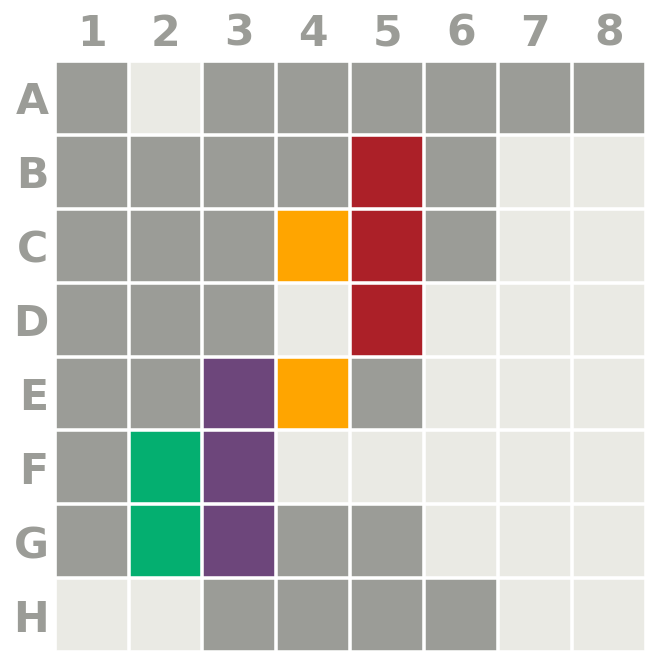

In [12]:
game

In [13]:
results_df = pd.concat([human_results_df, agent_results_df])
results_df["precision"] = results_df["hits"] / (results_df["hits"] + results_df["misses"])
results_df

,captainType,boardId,hits,misses,gameCompleted,questionsAsked,precision
0,human,B03,13,17,True,13,0.433333
1,human,B04,12,31,False,3,0.279070
2,human,B03,12,28,False,4,0.300000
3,human,B16,18,11,True,8,0.620690
4,human,B12,9,23,True,1,0.281250
...,...,...,...,...,...,...,...
113,human,B06,10,27,True,2,0.270270
114,human,B12,9,18,True,2,0.333333
0,RandomCaptain,B01,8,32,False,0,0.200000
1,MAPCaptain,B01,12,21,True,0,0.363636


In [14]:
# Compute average precision and fraction of games completed per captain type
# Split human results into three groups based on questionsAsked
human_mask = results_df["captainType"] == "human"
results_df_humans = results_df[human_mask].copy()

conditions = [
    results_df_humans["questionsAsked"] < 5,
    (results_df_humans["questionsAsked"] >= 5) & (results_df_humans["questionsAsked"] <= 10),
    results_df_humans["questionsAsked"] > 10
]
choices = ["below 5", "between 5 and 10", "above 10"]
results_df_humans["question_group"] = np.select(conditions, choices, default="unknown")

# Compute metrics for agent teams as before
avg_precision_agents = results_df.groupby("captainType")["precision"].mean()
frac_completed_agents = results_df.groupby("captainType")["gameCompleted"].mean()

# Compute metrics for human groups split by questions asked
avg_precision_humans = results_df_humans.groupby("question_group")["precision"].mean()
frac_completed_humans = results_df_humans.groupby("question_group")["gameCompleted"].mean()

# Combine the results for display
avg_precision = pd.concat([avg_precision_agents, avg_precision_humans])
frac_completed = pd.concat([frac_completed_agents, frac_completed_humans])

avg_precision, frac_completed

(MAPCaptain          0.363636
 Probabilistic       0.250000
 RandomCaptain       0.200000
 human               0.478040
 above 10            0.496567
 below 5             0.406242
 between 5 and 10    0.510944
 Name: precision, dtype: float64,
 MAPCaptain          1.000000
 Probabilistic       0.000000
 RandomCaptain       0.000000
 human               0.904348
 above 10            0.942308
 below 5             0.862069
 between 5 and 10    0.882353
 Name: gameCompleted, dtype: float64)

In [ ]:
import matplotlib.pyplot as plt

# Create two side-by-side bar plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

avg_precision.plot(kind="bar", ax=axes[0])
axes[0].set_ylabel("Average Precision")
axes[0].set_title("Average Precision by Captain Type")

frac_completed.plot(kind="bar", ax=axes[1])
axes[1].set_ylabel("Fraction of Completed Games")
axes[1].set_title("Fraction of Games Completed by Captain Type")

plt.tight_layout()
plt.show()